In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from math import sqrt
from statistics import mean

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('energy consumption.csv')

In [3]:
data.head()

,DATE,ENERGY_INDEX
0,01/1939,3.3842
1,02/1939,3.4100
2,03/1939,3.4875
3,04/1939,3.5133
4,05/1939,3.5133


In [4]:
data.dtypes

DATE             object
ENERGY_INDEX    float64
dtype: object

In [5]:
data.DATE = pd.to_datetime(data.DATE)

In [6]:
data.head()

,DATE,ENERGY_INDEX
0,1939-01-01,3.3842
1,1939-02-01,3.4100
2,1939-03-01,3.4875
3,1939-04-01,3.5133
4,1939-05-01,3.5133


In [7]:
data.dtypes

DATE            datetime64[ns]
ENERGY_INDEX           float64
dtype: object

In [8]:
data = data.resample('Y', on='DATE')['ENERGY_INDEX'].sum()

In [9]:
data.head()

DATE
1939-12-31    42.9866
1940-12-31    47.4043
1941-12-31    53.4749
1942-12-31    60.0627
1943-12-31    66.3663
Freq: A-DEC, Name: ENERGY_INDEX, dtype: float64

In [10]:
data.shape

(81,)

In [11]:
ts = data.reset_index()

In [12]:
ts.columns = ['DATE', 'ENERGY_INDEX']

In [13]:
ts.head()

,DATE,ENERGY_INDEX
0,1939-12-31,42.9866
1,1940-12-31,47.4043
2,1941-12-31,53.4749
3,1942-12-31,60.0627
4,1943-12-31,66.3663


In [14]:
ts.tail()

,DATE,ENERGY_INDEX
76,2015-12-31,1232.8973
77,2016-12-31,1227.5572
78,2017-12-31,1218.1957
79,2018-12-31,1271.1520
80,2019-12-31,949.3216


### As 2019 has data till Sep, so we would remove the year's data from the dataset.

In [15]:
ts = ts[:-1]

In [16]:
ts.shape

(80, 2)

### Check for missing values

In [17]:
(ts.DATE.max() - ts.DATE.min())/365

Timedelta('79 days 01:18:54.246575342')

#### No missing values.

#### Split the data into training & validation data.

In [18]:
ind = int(0.8 * ts.shape[0])

In [19]:
train_data = ts[:ind]
valid_data = ts[ind:]

In [20]:
train_data.shape, valid_data.shape

((64, 2), (16, 2))

In [21]:
train_data.tail()

,DATE,ENERGY_INDEX
59,1998-12-31,1041.5803
60,1999-12-31,1073.4892
61,2000-12-31,1104.3241
62,2001-12-31,1100.3554
63,2002-12-31,1132.4157


In [22]:
valid_data.head()

,DATE,ENERGY_INDEX
64,2003-12-31,1151.6148
65,2004-12-31,1168.6970
66,2005-12-31,1194.0715
67,2006-12-31,1189.9883
68,2007-12-31,1227.3610


In [23]:
valid_data.tail()

,DATE,ENERGY_INDEX
75,2014-12-31,1242.0942
76,2015-12-31,1232.8973
77,2016-12-31,1227.5572
78,2017-12-31,1218.1957
79,2018-12-31,1271.1520


In [24]:
train_data.dtypes

DATE            datetime64[ns]
ENERGY_INDEX           float64
dtype: object

In [25]:
valid_data.dtypes

DATE            datetime64[ns]
ENERGY_INDEX           float64
dtype: object

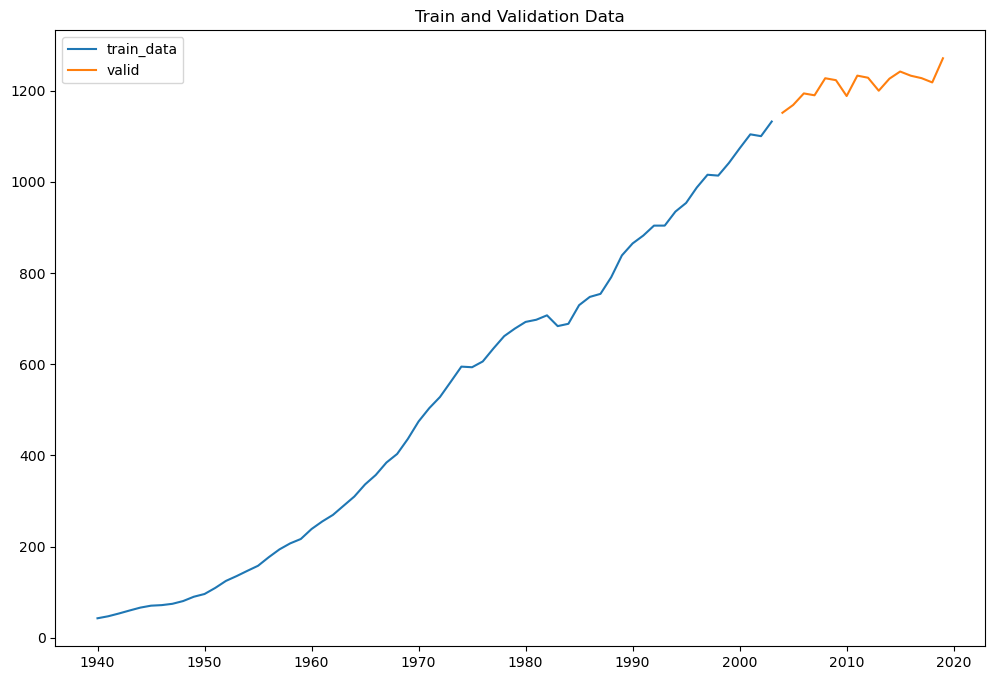

In [26]:
plt.figure(figsize=(12,8))

plt.plot(train_data['DATE'], train_data['ENERGY_INDEX'], label='train_data')
plt.plot(valid_data['DATE'], valid_data['ENERGY_INDEX'], label='valid')
plt.legend(loc='best')
plt.title("Train and Validation Data")
plt.show()

# Stationarity Test

In [27]:
# dickey fuller
from statsmodels.tsa.stattools import adfuller

In [28]:
def adf_test(timeseries):
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [29]:
adf_test(train_data['ENERGY_INDEX'])

Results of Dickey-Fuller Test:
Test Statistic                  2.432321
p-value                         0.999025
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64


Here, **Test Statistic > Critical Values** & **p-value > 0.05**. Hence, the Time Series is non-stationary.

# Making Time Series Stationary

In [30]:
train_data['ENERGY_INDEX_log'] = np.log(train_data['ENERGY_INDEX'])
train_data['ENERGY_INDEX_log_diff'] = train_data['ENERGY_INDEX'] - train_data['ENERGY_INDEX'].shift(1)

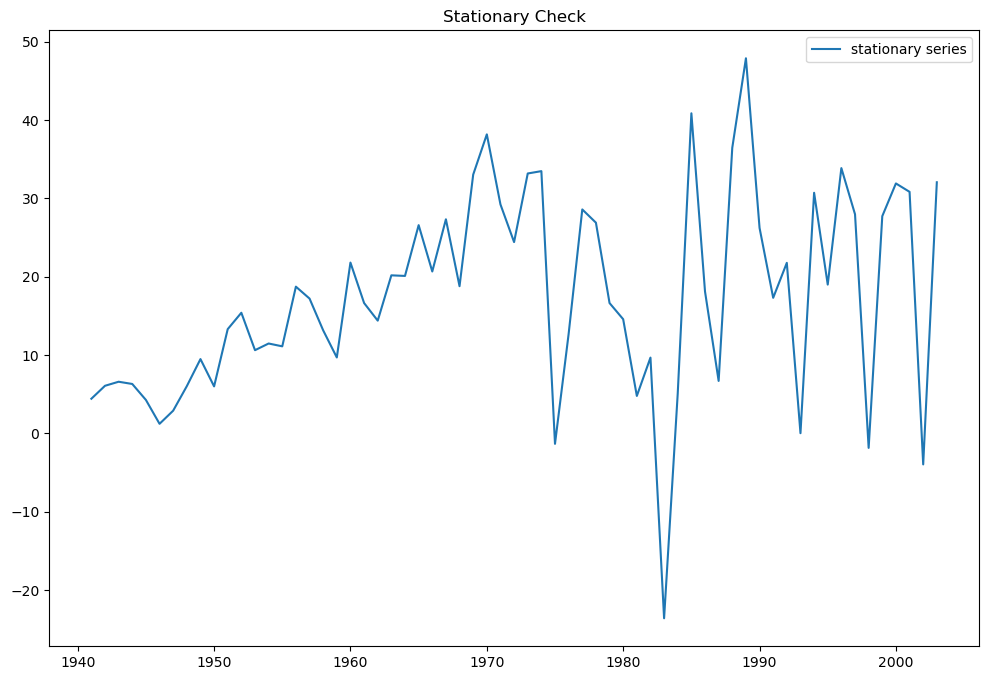

In [31]:
plt.figure(figsize=(12,8))

plt.plot(train_data['DATE'],train_data['ENERGY_INDEX_log_diff'], label='stationary series')
plt.legend(loc='best')
plt.title("Stationary Check")
plt.show()

In [32]:
adf_test(train_data['ENERGY_INDEX_log_diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -5.697949e+00
p-value                        7.795044e-07
#Lags Used                     0.000000e+00
Number of Observations Used    6.200000e+01
Critical Value (1%)           -3.540523e+00
Critical Value (5%)           -2.909427e+00
Critical Value (10%)          -2.592314e+00
dtype: float64


Now, the **Test Statistic is less than the Critical Values**. Besides, **p-value < 0.05**. Hence, the differentiated Time Series is now **Stationary**.

# ACF and PACF plots

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

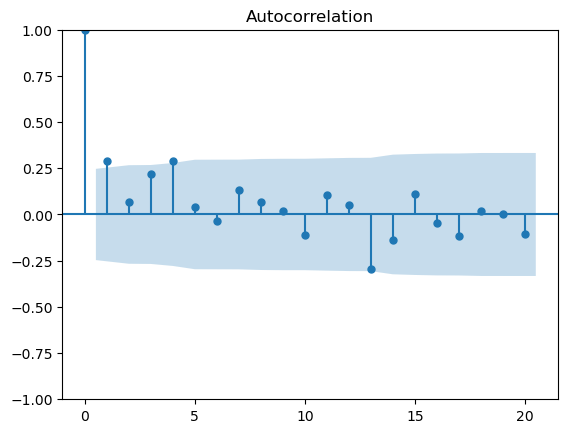

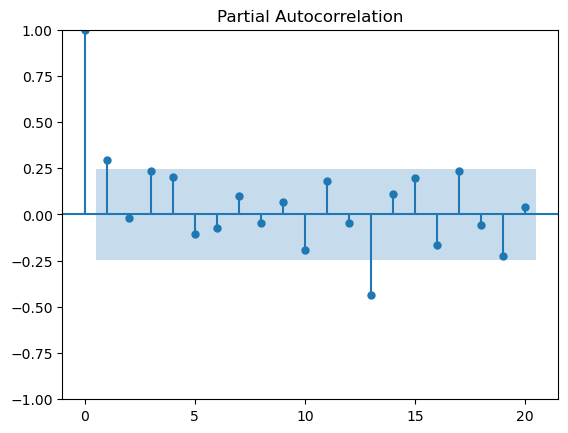

In [34]:
plot_acf(train_data['ENERGY_INDEX_log_diff'].dropna(), lags=20)
plot_pacf(train_data['ENERGY_INDEX_log_diff'].dropna(), lags=20)
plt.show()

# SARIMA

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [36]:
train_data['ENERGY_INDEX_log_diff'].head(10)

0       NaN
1    4.4177
2    6.0706
3    6.5878
4    6.3036
5    4.2624
6    1.2142
7    2.8932
8    6.0194
9    9.4808
Name: ENERGY_INDEX_log_diff, dtype: float64

In [37]:
# fit model
model = SARIMAX(train_data['ENERGY_INDEX_log'], order=(2,1,1))
model_output = model.fit()

In [38]:
valid_data.shape

(16, 2)

In [40]:
# generate forecasts
output_valid = model_output.forecast(16) 

valid_data['SARIMA'] = (pd.DataFrame(output_valid)).values

In [41]:
# to deal with log transformed values
valid_data['SARIMA'] = np.exp(valid_data['SARIMA'])

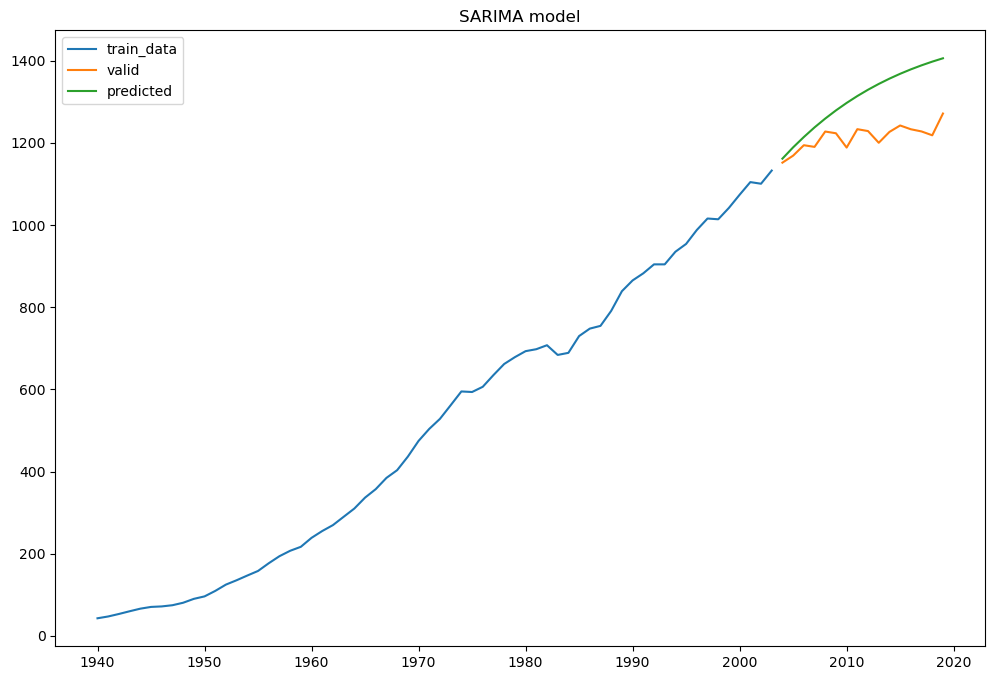

In [42]:
plt.figure(figsize=(12,8))

plt.plot(train_data['DATE'], train_data['ENERGY_INDEX'], label='train_data')
plt.plot(valid_data['DATE'], valid_data['ENERGY_INDEX'], label='valid')
plt.plot(valid_data['DATE'], valid_data['SARIMA'], label='predicted')

plt.legend(loc='best')
plt.title("SARIMA model")
plt.show()

In [43]:
# calculating RMSE 
rmse = sqrt(mean_squared_error(valid_data['ENERGY_INDEX'], valid_data['SARIMA']))
print('The RMSE value for SARIMA is', rmse)

The RMSE value for SARIMA is 107.84945261382924


## Now, forecast the energy consumption for the next 3 years based upon the above trained model.

In [45]:
# fit model on the full dataset
model_new = SARIMAX(ts['ENERGY_INDEX'], order=(2,1,1))
model_final = model_new.fit()

In [46]:
# Forecast the next 3 years
forecast_values = model_final.forecast(3)

In [47]:
# Create a date range for the next 3 years
last_date = ts['DATE'].iloc[-1]
forecast_dates = pd.date_range(start=last_date, periods=4, freq='Y')[1:]

In [48]:
# Create a DataFrame for the forecast values
final_df = pd.DataFrame({'DATE': forecast_dates, 'ENERGY_INDEX': forecast_values})

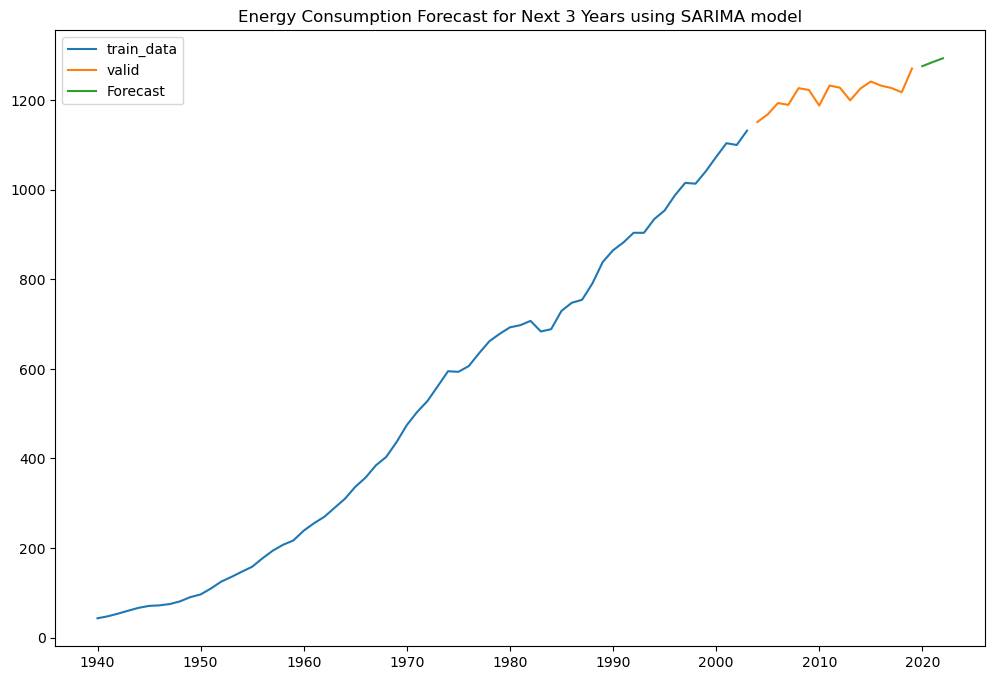

In [49]:
# Plot the final results
plt.figure(figsize=(12, 8))
plt.plot(train_data['DATE'], train_data['ENERGY_INDEX'], label='train_data')
plt.plot(valid_data['DATE'], valid_data['ENERGY_INDEX'], label='valid')
plt.plot(final_df['DATE'], final_df['ENERGY_INDEX'], label='Forecast')
plt.legend(loc='best')
plt.title("Energy Consumption Forecast for Next 3 Years using SARIMA model")
plt.show()

In [50]:
final_df.head()

,DATE,ENERGY_INDEX
80,2019-12-31,1276.397207
81,2020-12-31,1285.448052
82,2021-12-31,1294.040689
